In [20]:
# Common Imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Import Module
%run ./Module_DataImport.ipynb

# Data Visualization Module
%run ./Module_DataVisualization.ipynb

# Data Derivatives Module
%run ./Module_DataDerivatives.ipynb

## Deployment Information
In the code cell are variables that can be tuned based on the deployment, they are described in more detail below:
- student_list: a integer list of the students included in this study. Valid student numbers are between 2 and 9, inclusive.
- start_date: the first date that you would like to include in the summary. The earliest date that can be chosen that will ensure at least one student has data is 03/11/2019.
- end_date: the last date to include in the summary. No more data are available after 04/15/2019.

The start and end dates are defaulted to the earliest and latest dates, respectively, given in the description above. 

In [23]:
student_list = np.arange(2,10,1)
start_date = '04/01/2019'
end_date = '04/01/2019'
# Getting the number of hours
time_diff = datetime.strptime(end_date, '%m/%d/%Y') - datetime.strptime(start_date, '%m/%d/%Y')
num_hours = int(divmod(time_diff.total_seconds(),3600)[0])+24 # add 24 because we import all of the last day

## Data Import

### Indoor Environmental Quality Data
In the code cell below, the indoor environmental quality data is imported from the ```beacon_data``` directory available for Students 2 through 9. The variables include:
1. Temperature
2. Relative Humidity$^1$
3. PM2.5

The functions for importing the data are stored in the ```Module_DataImport.pynb``` notebook in the same directory as this master notebook. 

$^1$Temperature and Relative Humidity are imported together and stored in the same dataframe. Collectively, they are referred to as "thermal comfort"

In [24]:
TC_byStudent = pd.Series()
Concentration_byStudent = pd.Series()
for n in student_list:
    print()
    print('Importing IEQ Data for: Student',n)
    print('\nImporting Thermal Comfort Data...')
    TC_temp = ieqImport(str(n),'sht31d',['time','rh','temp'],'all',start_date,end_date)
    if len(TC_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        TC_byStudent['Student' + str(n)] = TC_temp
        print('\tImport Complete')
        
    print('\nImporting PM2.5 Concentration Data...')
    Concentration_temp = ieqImport(str(n),'pms5003',['time','PM2.5'],[0,2],start_date,end_date)
    if len(Concentration_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        Concentration_byStudent['Student' + str(n)] = Concentration_temp
        print('\tImport Complete')


Importing IEQ Data for: Student 2

Importing Thermal Comfort Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 3

Importing Thermal Comfort Data...
	Number of datapoints: 287
	Import Complete

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 4

Importing Thermal Comfort Data...
	Number of datapoints: 287
	Import Complete

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 5

Importing Thermal Comfort Data...
	Number of datapoints: 287
	Import Complete

Importing PM2.5 Concentration Data...
	No data from this deployment range
	Insufficient Data - not importing

Importing IEQ Data for: Student 6

Importing Thermal Comfort Data...
	Number

### Sleep Quality Data
There are two types of sleep quality data, gathered from different sources:
1. Sleep Stages from Fitbit
2. Perceived Sleep Quality from Beiwe EMA Surveys

Both datasets are imported below in the code cell.

In [5]:
SS_byStudent = pd.Series()
PSQ_byStudent = pd.Series()
for n in student_list:
    print('Importing Sleep Quality Data for: Student',n)
    SS_byStudent['Student' + str(n)] = fitbitImport(str(n),'S' + str(n) + '_SleepStages.csv',['Time','ShortWakes','Stage_Label'],[1,3,4])

Importing Sleep Quality Data for: Student 2
	Number of datapoints: 17059
Importing Sleep Quality Data for: Student 3
	Number of datapoints: 8466
Importing Sleep Quality Data for: Student 4
	Number of datapoints: 21853
Importing Sleep Quality Data for: Student 5
	Number of datapoints: 3080
Importing Sleep Quality Data for: Student 6
	Number of datapoints: 16727
Importing Sleep Quality Data for: Student 7
	Number of datapoints: 12519
Importing Sleep Quality Data for: Student 8
	Number of datapoints: 22820
Importing Sleep Quality Data for: Student 9
	Number of datapoints: 1096


## Single Variable Data Visualization
Below are visualizations that incorporate one variable.

### PM2.5
There are three main PM2.5 Concentration figures:
1. Time Series showing daily PM2.5 concentrations in their home
2. Time Series showing daily AQI for PM2.5 in their home
3. Bar Chart showing daily median concentrations in their home

#### PM2.5 Concentration Profile

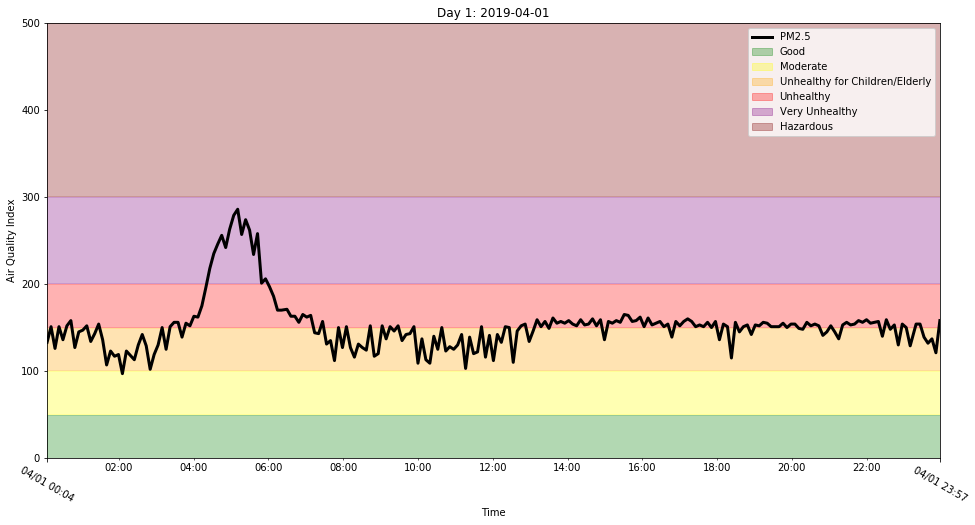

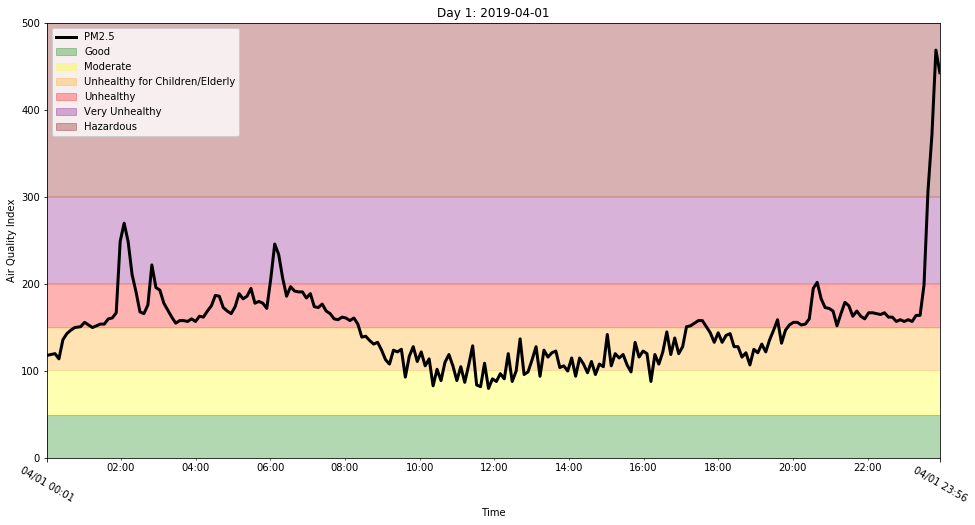

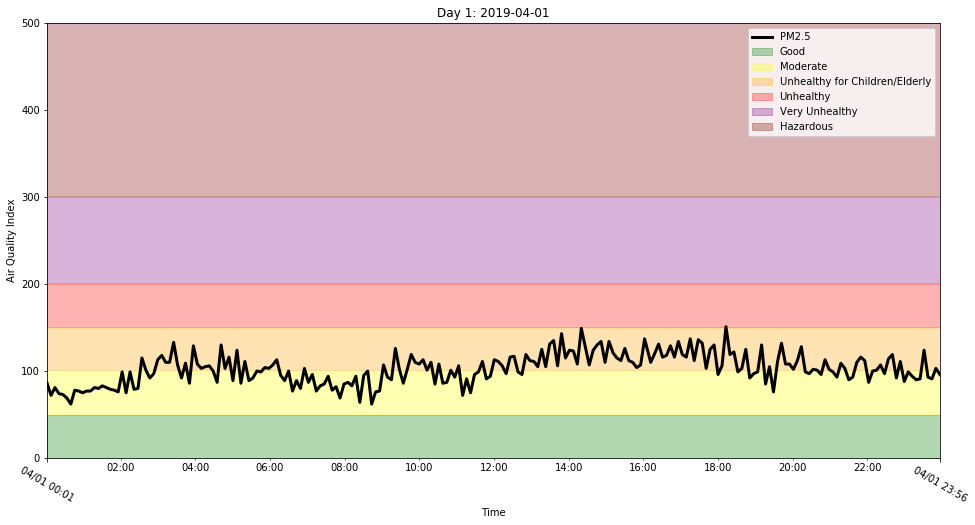

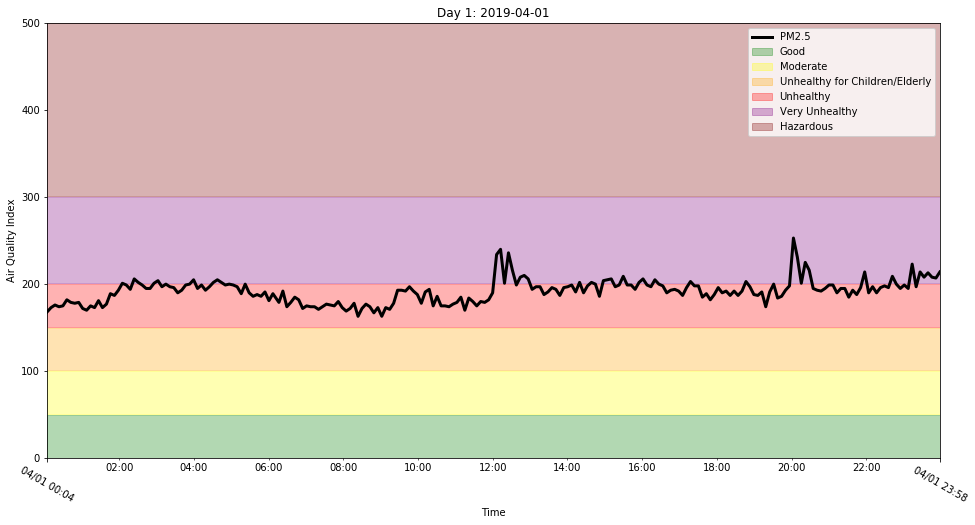

In [25]:
# Data Visualization Module
%run ./Module_DataVisualization.ipynb

# Looping through all the imported data
for name in Concentration_byStudent.index:
    ## Created new columns in the dataframe that store the month and date
    Concentration_byStudent[name]['mo'] = Concentration_byStudent[name].index.month        
    Concentration_byStudent[name]['day'] = Concentration_byStudent[name].index.day
    ## Splitting the dataframe by the month and day to get a dataframe per day
    agg = Concentration_byStudent[name].groupby(['mo','day'])
    
    ## Looping through the individual's days of data and plotting
    index = 0
    for group in agg:
        ### Converting the group into a dataframe
        group = pd.DataFrame(data=group[1])
        ### Plotting Concentration profile
        #getFinePMTimeSeries(group.index,group['PM2.5'],'Concentration ($\mu$g/m$^3$)',index+1)
        ### Plotting AQI profile
        getFinePMTimeSeries(group.index,getAQI(group['PM2.5']),'Air Quality Index',index+1)
        index += 1